quandl housing api:  
https://www.quandl.com/blog/api-for-housing-data

api key:  
11Uh5euqzE625yn6n5QG

In [3]:
%matplotlib inline

import sys
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np

import utils as ut

sns.set_context("talk")

In [4]:
hoods = ut.load_hoods()
cities = ut.load_cities()
counties = ut.load_counties()
indicators = ut.load_indicators()

preview

In [7]:
indicators.head()

,Indicator Name,Indicator Code
0,All Homes,A
1,Single Family Residences,SF
2,Condominiums,C
3,Price per Square Foot,MVSF
4,1 Bedroom,1B


build cities sale price df

In [76]:
px = ut.load_quandl_data('hoods','A')

In [77]:
px.shape

(233, 824)

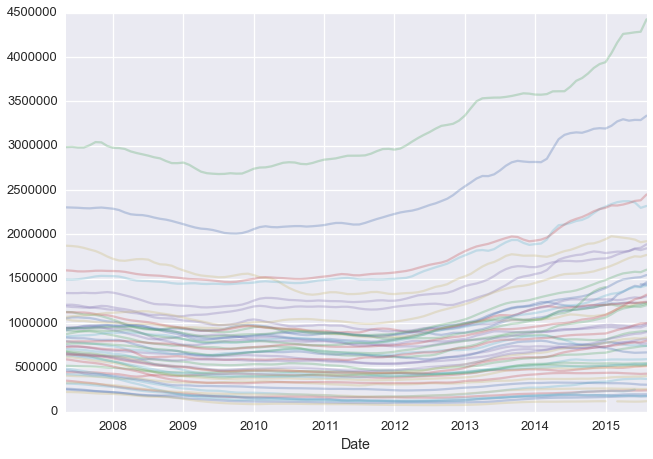

In [78]:
px.ix[-100:,-50:].plot(alpha=.3, legend=False)

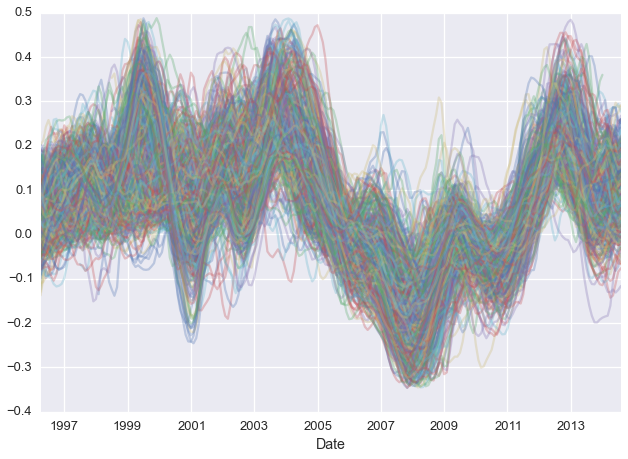

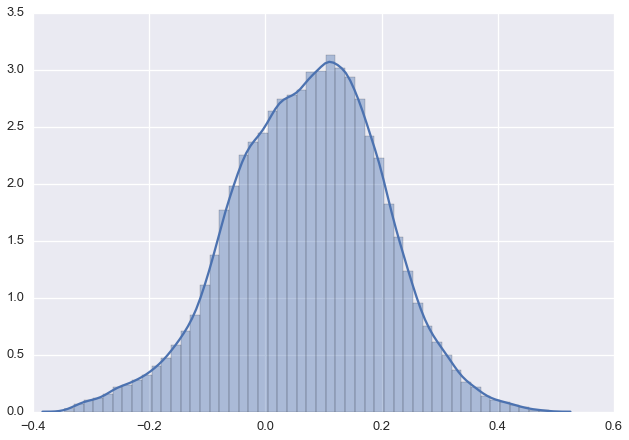

In [92]:
fwd_ret = ut.get_forward_return(px, periods=12)
fwd_ret.plot(legend=False, alpha=.3)
plt.figure()
sns.distplot(fwd_ret.stack())

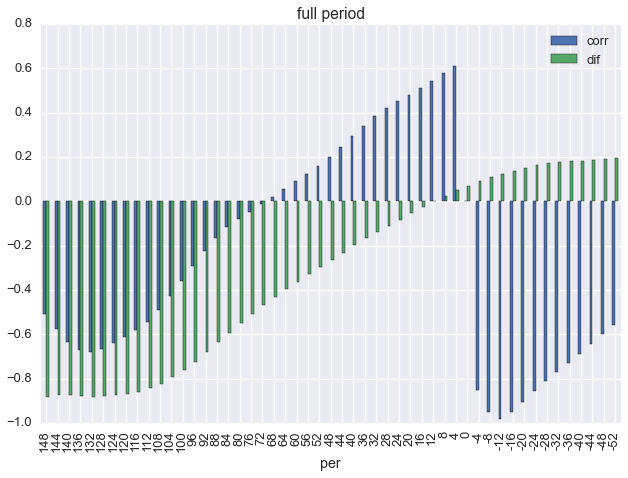

In [86]:
corr = ut.lead_lag_corr(px, fwd_ret)
corr.plot(kind='bar', title='full period')

{'f_test': None,
 'params': array([ 0.16198381]),
 'tvalues': array([ 262.96867296])}

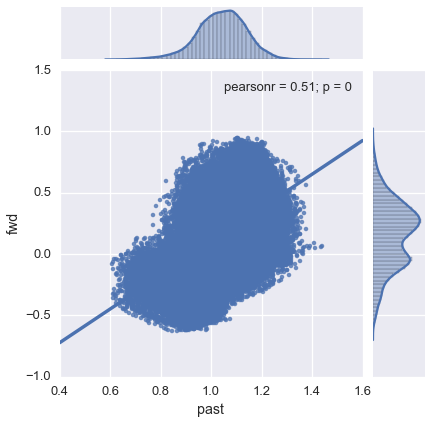

In [79]:
r = (px / px.shift(8))
df = pd.concat([r.stack().to_frame(), fwd_ret.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

{'f_test': None,
 'params': array([ 0.14446531]),
 'tvalues': array([ 246.50312376])}

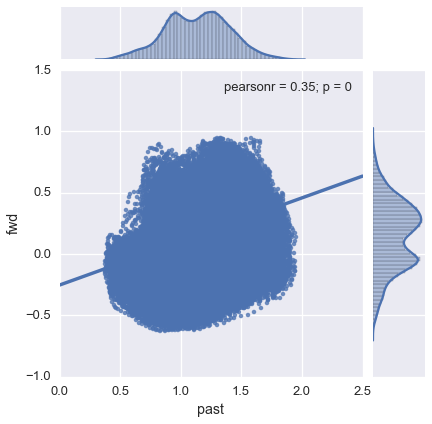

In [80]:
r = (px / px.shift(24))
df = pd.concat([r.stack().to_frame(), fwd_ret.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

{'f_test': None,
 'params': array([-0.03087683]),
 'tvalues': array([-71.27092696])}

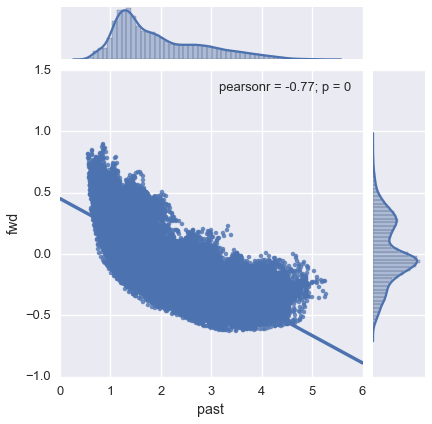

In [81]:
r = (px / px.shift(120))
df = pd.concat([r.stack().to_frame(), fwd_ret.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

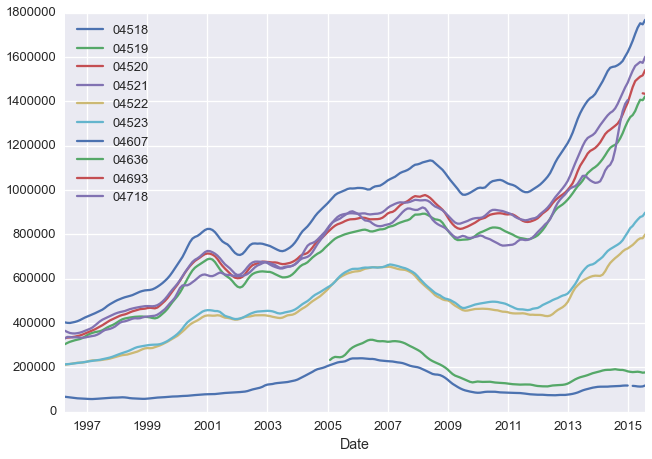

In [127]:
px.ix[:,-10:].plot()

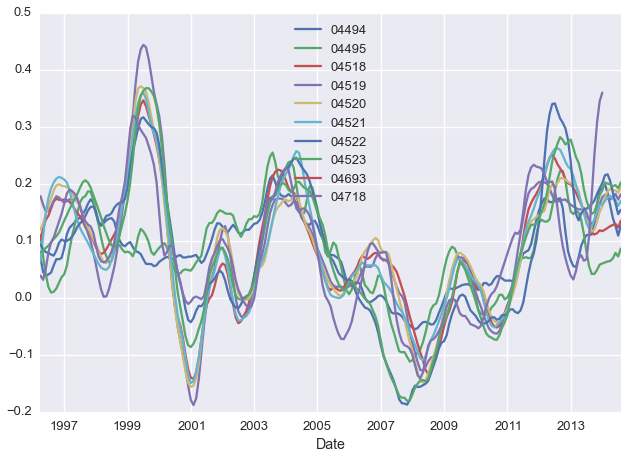

In [130]:
fwd_ret.ix[:,-10:].plot()

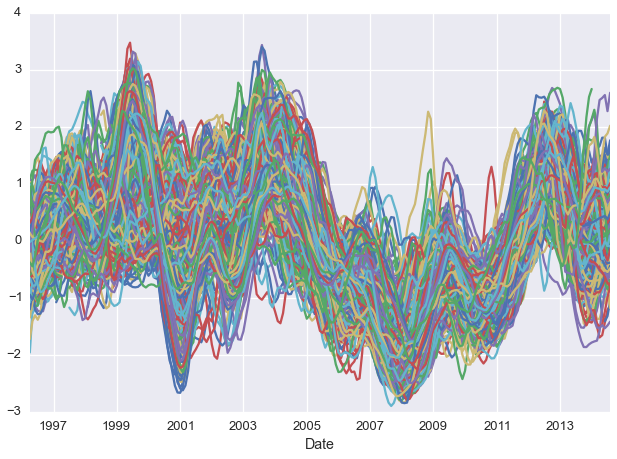

In [153]:
fwd_ret_ts = ut.ts_score(fwd_ret)
fwd_ret_ts.plot(legend=False)

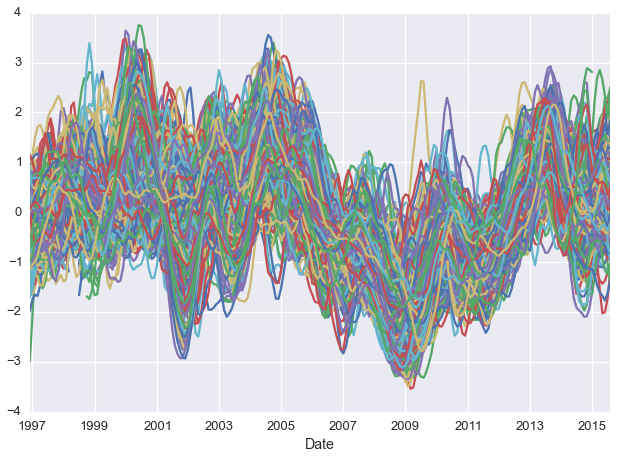

In [152]:
mom = ut.ts_score((px / px.shift(8)).dropna(how='all'))
mom.plot(legend=False)

In [160]:
df = ut.stack_and_align(mom, fwd_ret_ts, cols=['mom', 'fwd'])

In [174]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(df[['mom']], df['fwd'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [179]:
pred = pd.DataFrame(clf.predict(df[['mom']]), index=df.index, columns=['pred'])

In [230]:
d = ut.stack_and_align(ut.get_row_percentile(pred), df['fwd'])

In [257]:
quint = pd.DataFrame()
for i in range(2, 12, 2):
    i = i/10.
    quint[i] = d[(d.pred>(i-.2)) & (d.pred<i)]['fwd'].unstack().sum(axis=1)

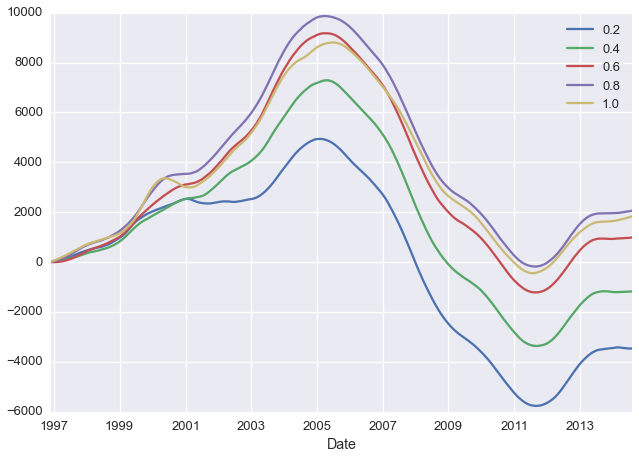

In [259]:
quint.cumsum().plot()

# mult scores by vol - use vol function tied to distance of returns